# Laboratorium 4 - rekomendacje dla portali informacyjnych

## Przygotowanie

 * pobierz i wypakuj dataset: https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
   * więcej możesz poczytać tutaj: https://learn.microsoft.com/en-us/azure/open-datasets/dataset-microsoft-news
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install nltk sklearn`

## Część 1. - przygotowanie danych

In [1]:
# importujemy wszystkie potrzebne pakiety

import codecs
from collections import defaultdict # mozesz uzyc zamiast zwyklego slownika, rozwaz wplyw na czas obliczen
import math
import re
from email.policy import default
from string import punctuation

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# mozesz uzyc do obliczania najbardziej podobnych tekstow zamiast liczenia "na piechote"
# ale pamietaj o dostosowaniu formatu danych
from sklearn.neighbors import NearestNeighbors

# na potrzeby wizualizacji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/radoslawcybulski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# definiujemy potrzebne zmienne

PATH = './MINDsmall_train'
STOPWORDS = set(stopwords.words('english'))

In [3]:
# wczytujemy metadane artykułów

def parse_news_entry(entry):
    news_id, category, subcategory, title, abstract = entry.split('\t')[:5]
    return {
        'news_id': news_id,
        'category': category,
        'subcategory': subcategory,
        'title': title,
        'abstract': abstract
    }

def get_news_metadata():
    with codecs.open(f'{PATH}/news.tsv', 'r', 'UTF-8') as f:
        raw = [x for x in f.read().split('\n') if x]
        parsed_entries = [parse_news_entry(entry) for entry in raw]
        return {x['news_id']: x for x in parsed_entries}

news = get_news_metadata()
news_ids = sorted(list(news.keys()))
news_indices = {x[1]: x[0] for x in enumerate(news_ids)}
print(len(news))

51282


In [4]:
def parse_history_entry(entry):
    _id, user_id, _time, history, _impressions = entry.split('\t')
    history = [x for x in history.split() if x]
    return user_id, history

def get_users_history():
    with codecs.open(f'{PATH}/behaviors.tsv', 'r', 'UTF-8') as f:
        lines = [x for x in f.read().split('\n') if x]
        entries = [parse_history_entry(x) for x in lines]
        return dict(entries)

users_history = get_users_history()
test_users = 'U53231', 'U89744', 'U10045', 'U92486', 'U70879'
print(len(users_history))

50000


## Część 2. - TF-IDF

In [15]:
from nltk import StemmerI
import string


# normalizujemy teksty na potrzeby dalszego przetwarzania

def preprocess_text(text: str) -> list[str]:
    # zamieniamy wszystkie ciagi bialych znakow na pojedyncze spacje
    text = " ".join(text.split())
    
    # usuwamy znaki interpunkcyjne
    for punc in string.punctuation:
        text = text.replace(punc, "")
        
    # usuwamy wszystkie liczby
    for digit in string.digits:
        text = text.replace(digit, "")
    
    # podmieniamy wszystkie wielkie litery
    text = text.lower()
    
    # dzielimy na tokeny
    tokens = text.split()
    
    # usuwamy stopwords
    tokens = [token for token in tokens if token not in STOPWORDS]
    
    return tokens

def stem_texts(corpus: list[str], *, stemmer: StemmerI = LancasterStemmer()) -> list[list[str]]:
    return [[stemmer.stem(word) for word in preprocess_text(text)] for text in corpus]

def lemmatize_texts(corpus: list[str], lemmatizer = WordNetLemmatizer()) -> list[list[str]]:
    nltk.download('wordnet')
    return [[lemmatizer.lemmatize(word) for word in preprocess_text(text)] for text in corpus]

texts: list[str] = [news[news_id]['abstract'] for news_id in news_ids]
stemmed_texts = lemmatize_texts(texts)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/radoslawcybulski/nltk_data...


In [16]:
# porownajmy teksty przed i po przetworzeniu

print(texts[2] + '\n')
print(' '.join(stemmed_texts[2]))

"I think we have a really good team, and a team that can really do some special, good things because that group is very close in there." - Brian Schmetzer

think really good team team really special good thing group close brian schmetzer


In [17]:
# tworzymy liste wszystkich slow w korpusie

def get_all_words_sorted(corpus: list[list[str]]) -> list[str]:
    # generujemy posortowana alfabetycznie liste wszystkich slow (tokenow)
    all_words = []
    for text in corpus:
        all_words.extend(text)
        
    return sorted(set(all_words))

wordlist = get_all_words_sorted(stemmed_texts)
word_indices = {x[1]: x[0] for x in enumerate(wordlist)}
print(len(wordlist))

51871


In [18]:
# obliczamy liczbe tekstow, w ktorych wystapilo kazde ze slow
# pamietaj, ze jesli slowo wystapilo w danym tekscie wielokrotnie, to liczymy je tylko raz

def get_document_frequencies(corpus: list[list[str]], wordlist: list[str]) -> dict[str, int]:
    frequencies = dict.fromkeys(wordlist, 0)
    for text in corpus:
        for word in set(text):
            frequencies[word] += 1
                
    return frequencies
        
document_frequency = get_document_frequencies(stemmed_texts, wordlist)

In [19]:
from collections import Counter


# obliczamy liczbe wystapien kazdego slowa w kazdym tekscie

def get_term_frequencies(corpus: list[list[str]], news_indices: dict[str, int]) -> dict[str, dict[str, int]]:
    # return {news_id -> {word -> count}}
    frequencies = {}
    for news_id, index in news_indices.items():
        frequencies[news_id] = dict(Counter(corpus[index]))
        
    return frequencies


term_frequency = get_term_frequencies(stemmed_texts, news_indices)

In [20]:
# sprawdzmy wyniki

term_frequency[news_ids[2]]

{'think': 1,
 'really': 2,
 'good': 2,
 'team': 2,
 'special': 1,
 'thing': 1,
 'group': 1,
 'close': 1,
 'brian': 1,
 'schmetzer': 1}

In [21]:
# obliczamy metryke tf_idf

def calculate_tf_idf(term_frequency: dict[str, dict[str, int]], document_frequency: dict[str, int], corpus_size: int) -> dict[str, dict[str, float]]:
    tf_idf = {news_id: {} for news_id in term_frequency.keys()}
    for news_id, frequencies in term_frequency.items():
        for word, frequency in frequencies.items():
            idf = math.log(corpus_size / document_frequency[word])
            tf_idf[news_id][word] = frequency * idf
    
    return tf_idf


tf_idf = calculate_tf_idf(term_frequency, document_frequency, len(news_ids))

In [22]:
# sprawdzmy wyniki

tf_idf[news_ids[2]]

{'think': 4.5279304056467895,
 'really': 9.707261090572182,
 'good': 8.107747259335776,
 'team': 6.19845372520361,
 'special': 4.836281906951478,
 'thing': 4.111693200556713,
 'group': 4.2686255233458485,
 'close': 4.762876182017627,
 'brian': 5.624739267315748,
 'schmetzer': 9.458800731274183}

## Część 3. - Podobieństwo tekstów

In [24]:
from typing import Literal


# obliczmy odleglosc miedzy dwoma artykulami
# przetestuj rozne metryki odleglosci i wybierz najlepsza

def calculate_distance(tf_idf: dict[str, dict[str, float]], id1: str, id2: str, metric: Literal["cosine", "euclidean"] = "cosine") -> float:
    tf_idf_1 = tf_idf[id1]
    tf_idf_2 = tf_idf[id2]
    words = sorted(list(set(tf_idf_1.keys()) | set(tf_idf_2.keys())))
    v1 = [tf_idf_1.get(word, 0) for word in words]
    v2 = [tf_idf_2.get(word, 0) for word in words]
    
    match metric:
        case "cosine":
            return _cosine_distance(v1, v2)
        case "euclidean":
            return _euclidean_distance(v1, v2)
        case "manhattan":
            return _manhattan_distance(v1, v2)
        case "hamming":
            return _hamming_distance(v1, v2)
        case _:
            raise ValueError(f"Unknown metric: {metric}")
    

    
def _manhattan_distance(v1: list[float], v2: list[float]) -> float:
    return sum([abs(x - y) for x, y in zip(v1, v2)])
    
    
def _euclidean_distance(v1: list[float], v2: list[float]) -> float:
    return math.sqrt(sum([(x - y) ** 2 for x, y in zip(v1, v2)]))
    

def _hamming_distance(v1: list[float], v2: list[float]) -> float:
    return sum([x != y for x, y in zip(v1, v2)])
    
def _cosine_distance(v1: list[float], v2: list[float]) -> float:
    dot_product = sum([x * y for x, y in zip(v1, v2)])
    v1_norm = math.sqrt(sum([x ** 2 for x in v1]))
    v2_norm = math.sqrt(sum([x ** 2 for x in v2]))
    try:
        return 1 - dot_product / (v1_norm * v2_norm)
    except ZeroDivisionError:
        return 1


calculate_distance(tf_idf, news_ids[2], news_ids[1])

0.9776903663919716

In [25]:
# funkcja pomocnicza do wyswietlania artykulow
def print_news_entry(n_id, corpus):
    print(f'id: {n_id}\n\ttitle: {corpus[n_id]["title"]}\n\ttext: {corpus[n_id]["abstract"]}')

print_news_entry('N42782', news)

id: N42782
	title: Three takeaways from Yankees' ALCS Game 5 victory over the Astros
	text: The Yankees kept hope alive thanks to some impressive starting pitching and a pair of early home runs.


In [26]:
# wyznaczmy k najpodobniejszych tekstow do danego
# pamietaj o odpowiedniej kolejnosci sortowania w zaleznosci od wykorzystanej metryki
# pamietaj, zeby wsrod podobnych tekstow nie bylo danego

def get_k_most_similar_news(tf_idf: dict[str, dict[str, float]], n_id: str, k: int):
    news_ids = list(tf_idf.keys())
    texts_with_distances = [(news_id, calculate_distance(tf_idf, n_id, news_id)) for news_id in news_ids if n_id != news_id]
    texts_with_distances.sort(key=lambda x: x[1])
    return [x[0] for x in texts_with_distances[:k]]
    

def print_k_most_similar_news(tf_idf: dict[str, dict[str, float]], n_id: str, k: int, corpus: list[list[str]]):
    similar = get_k_most_similar_news(tf_idf, n_id, k)
    print_news_entry(n_id, corpus)
    print(f'\n{k} most similar:')
    for s_id in similar:
       print_news_entry(s_id, corpus)

print_k_most_similar_news(tf_idf, news_ids[42337], 5, news)

id: N58544
	title: Tiny Electric Car Cost $420,000 To Build
	text: A MAN claims he has created a car that might solve the world's traffic congestion problems. Rick Woodbury from Spokane, Washington USA, is the president, founder and sole employee of 'Commuter Cars.' The carmaker's flagship model is the 2005 super slim two-seater Tango T600, a high-performance electric car that preceded Tesla. Rick told BTV: "I started this company 21 years ago   it was based on an idea that I came up with in 1982." He was inspired by the shocking traffic congestion he had to face on a daily basis. "I used to drive a Porsche from Beverly Hills to Hermosa Beach every day and the traffic was horrendous," explained Rick. What really made Rick think about a solution was the fact that in most of the cars he would see in his commute were occupied by lone drivers. "I noticed that everybody around me was a single occupant in a car, taking up the whole lane," Rick said. Living and working in Los Angeles also hel

## Część 4. - Profile użytkowników

In [27]:
# oblicz srednia z wektorow tf-idf artykulow o zadanych id-kach
def calculate_average_vector(tf_idf: dict[str, dict[str, float]], news_ids: list[str]) -> dict[str, float]:
    average_vector = defaultdict(float)
    
    for news_id in news_ids:
        for word, value in tf_idf[news_id].items():
            average_vector[word] += value
            
    for word in average_vector.keys():
        average_vector[word] /= len(news_ids)
        
    return average_vector

# wykorzystaj powyzsza funkcje, by policzyc wektor kazdego uzytkownika
def calculate_users_vectors(tf_idf, users_history: dict[str, list[str]]) -> dict[str, list]:
    users_vectors = {}
    for user_id, news_ids in users_history.items():
        users_vectors[user_id] = calculate_average_vector(tf_idf, news_ids)
        
    return users_vectors

user_vectors = calculate_users_vectors(tf_idf, users_history)

In [28]:
# sprawdz wyliczony profil dla przykladowego uzytkownika
print(sorted([(k,v) for k,v in user_vectors[test_users[0]].items() if v], key=lambda x: -x[1]))

[('fire', 1.3519562371795322), ('plane', 1.1701285777724966), ('diaz', 0.9848359105446637), ('paula', 0.8214687066477994), ('acre', 0.8090445060145697), ('ventura', 0.7780260164933531), ('flight', 0.7527351413211081), ('maria', 0.7407074421074729), ('hailstone', 0.7251391365595806), ('aircraft', 0.7197815043588195), ('storm', 0.7003279596096246), ('landing', 0.6898259834067665), ('chaser', 0.6756286236624416), ('ditching', 0.6466668302261441), ('tornado', 0.6380084961613199), ('noaa', 0.6261181107653027), ('twoweek', 0.6177050367898467), ('airline', 0.61297833353473), ('consuming', 0.6033714156854073), ('storyful', 0.6009271210247275), ('california', 0.5954302330209911), ('santa', 0.5734321766843061), ('containment', 0.5476458044318663), ('may', 0.5474399003934919), ('large', 0.5466527040626348), ('according', 0.5448385719446568), ('filming', 0.5447299476804195), ('ef', 0.5366350415870621), ('tanker', 0.5317069793379942), ('gaming', 0.5248991093519709), ('mandatory', 0.5227667548412794

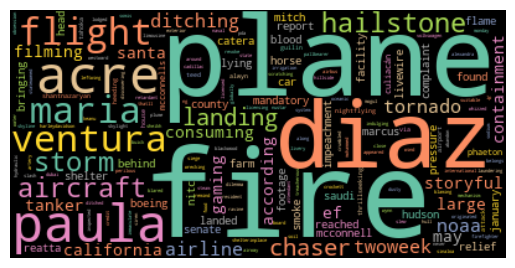

In [29]:
# skorzystajmy ze znanej juz biblioteki, by to lepiej zwizualizowac
def plot_vector(tf_idf_vector):
    wordcloud = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud.generate_from_frequencies(frequencies=tf_idf_vector)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_vector(user_vectors[test_users[0]])

## Część 5. - Rekomendacje dla użytkowników

In [53]:
# wykorzystujac wektory tresci i profile uzytkownikow,
#   wygeneruj liste k artykulow najlepiej dopasowanych do uzytkownika
#   pamietaj o odsianiu artykulow, ktore uzytkownik juz kliknal

def recommend(
    tf_idf: dict[str, dict[str, float]],
    user_vector: dict[str, float],
    user_history: dict[str, list[str]],
    news: list[str],
    k: int,
    metric: Literal["cosine", "euclidean"] = "cosine"
) -> list[str]:
    news_with_distances = [
        (news_id, _user_news_distance(tf_idf, user_vector, news_id, metric=metric))
        for news_id in news
        if news_id not in user_history
    ]
    
    news_with_distances.sort(key=lambda x: x[1])
    return [x[0] for x in news_with_distances[:k]]


def _user_news_distance(tf_idf: dict[str, dict[str, float]], user_vector: dict[str, float], news_id: str, metric: Literal["cosine", "euclidean"] = "cosine") -> float:
    news_vector = tf_idf[news_id]
    words = sorted(list(set(user_vector.keys()) | set(news_vector.keys())))
    v1 = [user_vector.get(word, 0) for word in words]
    v2 = [news_vector.get(word, 0) for word in words]
    match metric:
        case "cosine":
            return _cosine_distance(v1, v2)
        case "euclidean":
            return -_euclidean_distance(v1, v2)
        case _:
            raise ValueError(f"Unknown metric: {metric}")

# dla wybranego uzytkownika, korzystajac z juz zaimplementowanych funkcji,
#   pokaz jego historie, profil (wordcloud) i rekomendacje
user_id = test_users[0]
print(f'user: {user_id}')

user: U53231


In [54]:
print('history:')
for news_id in users_history[user_id]:
    print_news_entry(news_id, news)

history:
id: N58936
	title: Beloved grandfather's body pulled from collapsed Hard Rock hotel
	text: A family holding vigil outside the site of the Hard Rock hotel construction collapse received the news they hoped they'd never hear.
id: N15919
	title: Saddleridge fire calms down, heavy rains on East Coast
	text: A new storm system is developing in the southern Plains and will move east over the next few days bringing a threat of flooding to the South with rain and gusty winds.
id: N11917
	title: JetBlue Plane Makes Emergency Landing at JFK Airport
	text: The plane landed safely in NYC Sunday night.
id: N2153
	title: Iran alleges foreign government behind 'treacherous' ship attack
	text: Iran said Monday a foreign government was behind what it alleges was a "treacherous" attack on a tanker off Saudi Arabia last week, as it released pictures of its damaged hull. But the state-owned NITC denied reports the alleged attack had originated from Saudi soil.
id: N55312
	title: Why are most airc


profile:


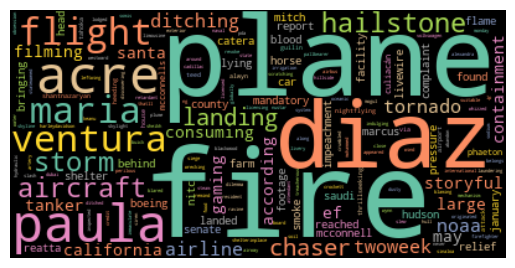

In [55]:
print('\nprofile:')
plot_vector(user_vectors[user_id])

In [56]:
print('\nrecommendations:')
for news_id in recommend(tf_idf, user_vectors[user_id], users_history[user_id], news, 5):
    print_news_entry(news_id, news)


recommendations:
id: N58169
	title: Helicopter crews take on California's Maria fire with nighttime flights
	text: Ventura County Fire crews battling the Maria Fire in California used nighttime helicopter flights to control the blaze, according to local authorities. "Helicopters that fight fire at night are not common. They take special knowledge, skills, training and technology," Ventura County Fire wrote on Twitter. The Maria Fire broke out in the hills above Santa Paula and began to spread on Thursday evening, October 31. By the evening of November 3, authorities said, the fire has grown to 9,412 acres but was 70 percent contained. Only two structures were destroyed by the fire, but widespread evacuation orders were in place. The Ventura County Sheriff said that 1,800 structures were threatened as the fire grew on October 31 and that 7,500 people were under evacuation orders. Credit: Ventura County Fire via Storyful
id: N58561
	title: Wildfire Alert Cameras Captures Ignition and Sp

## Część 6. - Ocena jakości

In [57]:
# jaccard index to metryka podobienstwa zbiorow, lekko ja zmodyfikujemy
# przeciecie wektorow to minimum po kazdej wspolrzednej
# unia wektorow to maksimum po kazdej wspolrzednej
# jaccard index to iloraz sum tych dwoch wartosci

def jaccard(v1: dict[str, float], v2: dict[str, float]) -> float:    
    all_words = set(v1.keys()) | set(v2.keys())
    intersection_sum = sum(min(v1.get(word, 0), v2.get(word, 0)) for word in all_words)
    union_sum = sum(max(v1.get(word, 0), v2.get(word, 0)) for word in all_words)
    
    return intersection_sum / union_sum if union_sum else 0

In [59]:
# dla kazdego uzytkownika wygeneruj k-elementowa rekomendacje
# policz jaccard index miedzy wektorem uzytkownika a srednim wektorem elementow z rekomendacji
# porownaj wyniki dla dwoch roznych k i dwoch roznych metryk podobienstwa

for user_id in test_users:
    for k in [5, 10]:
        for metric in ["cosine", "euclidean"]:
                user_vector = user_vectors[user_id]
                user_history = users_history[user_id]
                recommendations = recommend(tf_idf, user_vector, user_history, news, k, metric)
                average_vector = calculate_average_vector(tf_idf, recommendations)
                similarity = jaccard(user_vector, average_vector)
                print(f"{user_id} {k} {metric} {similarity}")

U53231 5 cosine 0.049528536375679354
U53231 5 euclidean 0.012829184705349323
U53231 10 cosine 0.06290710386800842
U53231 10 euclidean 0.020836231456253445
U89744 5 cosine 0.032713358626399625
U89744 5 euclidean 0.010047047807860324
U89744 10 cosine 0.04940991051735964
U89744 10 euclidean 0.017620365094024846
U10045 5 cosine 0.04634183093551656
U10045 5 euclidean 0.01088770948143757
U10045 10 cosine 0.06278320829103184
U10045 10 euclidean 0.020515312326201525
U92486 5 cosine 0.03637745746051582
U92486 5 euclidean 0.010911302923323731
U92486 10 cosine 0.04112219658316667
U92486 10 euclidean 0.017810371847016622
U70879 5 cosine 0.02231316085671038
U70879 5 euclidean 0.01002910318457279
U70879 10 cosine 0.044643960914212605
U70879 10 euclidean 0.015924464103351604
